In [37]:
import yfinance as yf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [44]:
nvda = yf.Ticker("NVDA")
nvda = nvda.history(period="max")

del nvda['Dividends']
del nvda['Stock Splits']

<Axes: xlabel='Date'>

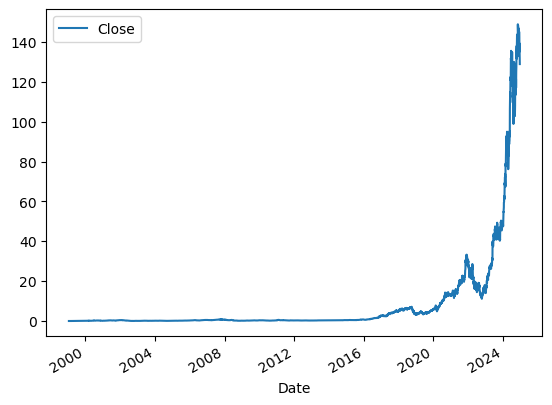

In [46]:
nvda.plot.line(y="Close", use_index = True)

In [50]:
nvda['Tomorrow'] = nvda['Close'].shift(-1)

In [49]:
nvda["Target"] = (nvda["Tomorrow"] > nvda["Close"]).astype(int)
nvda

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1999-01-22 00:00:00-05:00,0.040122,0.044779,0.035585,0.037615,2714688000,0.041556,1
1999-01-25 00:00:00-05:00,0.040600,0.042033,0.037615,0.041556,510480000,0.038331,0
1999-01-26 00:00:00-05:00,0.042033,0.042869,0.037734,0.038331,343200000,0.038212,0
1999-01-27 00:00:00-05:00,0.038451,0.039406,0.036301,0.038212,244368000,0.038092,0
1999-01-28 00:00:00-05:00,0.038212,0.038451,0.037854,0.038092,227520000,0.036301,0
...,...,...,...,...,...,...,...
2024-12-12 00:00:00-05:00,137.080002,138.440002,135.800003,137.339996,159211400,134.250000,0
2024-12-13 00:00:00-05:00,138.940002,139.600006,132.539993,134.250000,231514900,132.000000,0
2024-12-16 00:00:00-05:00,134.179993,134.399994,130.419998,132.000000,237951100,130.389999,0


In [52]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = nvda.iloc[:-100]
test = nvda.iloc[-100:]

predictors = ['Close', 'Volume', 'Open', 'High', 'Low']
model.fit(train[predictors], train['Target'])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [56]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index = test.index)
preds

Date
2024-07-30 00:00:00-04:00    1
2024-07-31 00:00:00-04:00    1
2024-08-01 00:00:00-04:00    1
2024-08-02 00:00:00-04:00    1
2024-08-05 00:00:00-04:00    1
                            ..
2024-12-12 00:00:00-05:00    0
2024-12-13 00:00:00-05:00    0
2024-12-16 00:00:00-05:00    0
2024-12-17 00:00:00-05:00    0
2024-12-18 00:00:00-05:00    0
Length: 100, dtype: int64

In [ ]:
precision_score(test["Target"], preds)

0.5625

<Axes: xlabel='Date'>

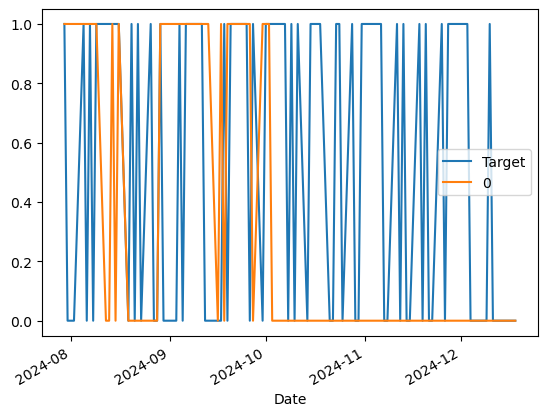

In [59]:
combined = pd.concat([test['Target'], preds], axis=1)
combined.plot()

In [62]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [63]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [64]:
predictions = backtest(nvda, model, predictors)

In [65]:
predictions["Predictions"].value_counts()

Predictions
0    2340
1    1680
Name: count, dtype: int64

In [66]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5190476190476191

In [67]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.529602
0    0.470398
Name: count, dtype: float64

In [69]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = nvda.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    nvda[ratio_column] = nvda["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    nvda[trend_column] = nvda.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [72]:
nvda = nvda.dropna()
nvda

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2003-01-15 00:00:00-05:00,0.094536,0.095301,0.091555,0.091555,904584000,0.085365,0,0.984386,1.0,0.979717,3.0,0.906372,32.0,0.453885,104.0,0.474865,470.0
2003-01-16 00:00:00-05:00,0.090180,0.091326,0.084143,0.085365,2039976000,0.082155,0,0.965011,0.0,0.928511,2.0,0.844110,31.0,0.426600,104.0,0.442657,469.0
2003-01-17 00:00:00-05:00,0.083072,0.084219,0.081086,0.082155,1058832000,0.080092,0,0.980839,0.0,0.918331,1.0,0.812207,30.0,0.413811,104.0,0.425916,469.0
2003-01-21 00:00:00-05:00,0.083684,0.085442,0.079862,0.080092,967356000,0.080169,1,0.987282,0.0,0.923510,1.0,0.792346,29.0,0.406730,103.0,0.415128,469.0
2003-01-22 00:00:00-05:00,0.079863,0.082232,0.079633,0.080169,550992000,0.082385,1,1.000481,1.0,0.955902,1.0,0.793078,30.0,0.410637,103.0,0.415437,470.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-11 00:00:00-05:00,137.360001,140.169998,135.210007,139.309998,184905200,137.339996,0,1.015453,1.0,0.994092,1.0,1.027019,35.0,1.342020,142.0,3.150524,537.0
2024-12-12 00:00:00-05:00,137.080002,138.440002,135.800003,137.339996,159211400,134.250000,0,0.992879,1.0,0.990952,1.0,1.009522,35.0,1.318520,141.0,3.097283,536.0
2024-12-13 00:00:00-05:00,138.940002,139.600006,132.539993,134.250000,231514900,132.000000,0,0.988623,0.0,0.980242,1.0,0.984832,34.0,1.284643,140.0,3.019358,536.0


In [73]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [74]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [75]:
predictions = backtest(nvda, model, new_predictors)

In [76]:
predictions["Predictions"].value_counts()

Predictions
0.0    2753
1.0     266
Name: count, dtype: int64

In [77]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5827067669172933